ADD COLAB BADGE (kida) 

In [ ]:
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d bwandowando/ukraine-russian-crisis-twitter-dataset-1-2-m-rows
!unzip ukraine-russian-crisis-twitter-dataset-1-2-m-rows.zip -d dataset
!rm ukraine-russian-crisis-twitter-dataset-1-2-m-rows.zip

In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [95]:
import csv
import datetime
import hashlib
import os
import pathlib
import pickle
import random
import re
import string
import timeit
import unicodedata
from collections import defaultdict
from itertools import combinations
from typing import Callable, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
import torch
import torch.nn.functional as F
from nltk.corpus import stopwords
from scipy.optimize import fsolve
from scipy.stats import kendalltau, spearmanr
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModel

In [3]:
spacy.prefer_gpu()
nlp = spacy.load('en_core_web_sm', exclude=['parser', 'ner'])
stops = set(stopwords.words('english'))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Implementation

## Hash utils

In [4]:
def is_prime(n: int) -> bool:
    if n < 2:
        return False
    for i in range(2, int(np.sqrt(n))+1):
        if (n % i) == 0:
            return False
    return True

def find_closest_prime(n: int) -> int:
    """Finds the closest prime number higher than input."""
    while True:
        if is_prime(n):
            return n
        n += 1

def get_variable_length_hash(
    n_bits: int
) -> Callable[[str], int]:
    """Generates a hash function that takes a string
    as input and has 2 ** n_bits integer buckets.
    """
    def inner_f(s: str) -> int:
        binary_str = bin(
            int.from_bytes(
                hashlib.sha256(s.encode()).digest(), 
                'little'
            )
        )[-n_bits:]
        return int(binary_str, 2)
    return inner_f

class HashGenerator:
    """Generator of hash functions of the form:
            
            h(x) = (ax + b) mod c
    
    where x is a row number, a and b are random numbers
    smaller than the maximum row number and c is a prime
    number higher than the maximum row number.

    Note that a and b must be unique for a given signature
    matrix.

    This approach to hash function generation was suggested
    in [1].

    Parameters
    ----------
    num_rows : int
        Maximum number of rows of the characteristic matrix.

    References
    ----------
        [1] http://ethen8181.github.io/machine-learning/clustering_old/text_similarity/text_similarity.html

    """
    def __init__(
        self, 
        num_rows: int, 
    ) -> None:
        self.num_rows = num_rows
        self.prime = find_closest_prime(num_rows)
        self.a_set = set()
        self.b_set = set()

    def get_num_rows(self) -> int:
        return self.num_rows

    def next(self) -> Callable[[np.uint32], np.uint32]:
        """Returns a hash function that takes a row number 
        as input and returns another row number as output.
        """
        a = self._generate_coeff(self.a_set, self.num_rows)
        b = self._generate_coeff(self.b_set, self.num_rows)
        return lambda row: np.uint32((a * row + b) % self.prime)

    def _generate_coeff(
        self, 
        coeff_set: set[int],
        max_val: int
    ) -> int:
        while True:
            coeff = random.randint(1, max_val)
            if coeff not in coeff_set:
                coeff_set.add(coeff)
                return coeff

## Preprocessing utils

In [5]:
def normalize_white_space(doc: str) -> str:
    return " ".join(doc.split())

def remove_https(doc: str) -> str:
    return re.sub(r'https?://[^ ]+', '', doc)

def replace_chars(doc: str) -> str:
    return doc.replace('&amp;', ' and ')

def remove_non_ascii(doc: str) -> str:
    """Removes non ascii and non printable characters.
    We keep cyrillic characters due to the nature
    of the dataset.
    """
    cyr_chars = "АаБбВвГгДдЕеЁёЖжЗзИиЙйКкЛлМмНнОоПпРрСсТтУуФфХхЦцЧчШшЩщЪъЫыЬьЭэЮюЯя"

    res = ""
    for c in doc:
        if (c.isascii() and c.isprintable()) \
            or (c in cyr_chars) or c.isspace():
            res += c
    return res

def strip_accents(doc: str) -> str:
    """Replaces words with accent with their 
    counterpart without accent. This also deals with 
    special characters such as 𝕒, 𝕕, 𝕖, 𝙖, 𝙘, 𝙙. 
    """
    return unicodedata.normalize('NFKD', doc)

def strip_punctuation(doc: str) -> str:
    return re.sub('[' + re.escape(string.punctuation) + ']+', '', doc)
    
def get_lemmatizer( 
    nlp: spacy.pipeline, 
    allow_stop_words: bool = False,
    allow_punct: bool = False,
    allow_numbers: bool = False
) -> Callable[[str], str]:
    """Generates a function that takes a string as
    input and returns the string sequence of lemmas
    in the input string. Optionally, the generated
    function removes stop words, punctuation and
    numbers.

    Note that numbers are tokens identified as such.
    For instance, '62,000' is a number, but 'T-72' is
    not.

    Parameters
    ----------
    nlp : spacy.pipeline
        Spacy object that carries out the lemmatization.
    
    allow_stop_words : bool
        Boolean value to filter or allow stop words.

    allow_punct : bool
        Boolean value to filter or allow punctuation.
    
    allow_numbers : bool
        Boolean value to filter or allow numbers.

    Returns
    -------
    The generated function. 
    """
    def inner_f(doc: str) -> str:
        return ' '.join(
            [
                token.lemma_
                for token in nlp(doc)
                if (not token.is_stop or allow_stop_words) \
                    and (not token.is_punct or allow_punct) \
                    and (token.pos_ != 'NUM' or allow_numbers) \
                    and (not token.pos_ == 'X')
            ]
        )
    return inner_f

def remove_handles(doc: str) -> str:
    return re.sub(r'@\w+', '', doc)

def remove_short(n: int) -> Callable[[str], str]:
    def inner_f(doc: str) -> str:
        if len(doc) < n:
            return ''
        else:
            return doc

    return inner_f

def get_stopwords_remover(
    stops: list[str]
) -> Callable[[str], str]:
    def inner_f(doc: str) -> str:
        return ' '.join(
            [
                token for token in doc.split()
                if token not in stops
            ]
        )
    return inner_f

## Model

In [6]:
def jaccard_similarity(
    x: np.ndarray, 
    y: np.ndarray
) -> float:
    numerator = len(set(x).intersection(set(y)))
    denominator = len(set(x).union(set(y)))
    return numerator / denominator

class LSHModel:
    """Implementation of LSH model that finds similar pairs
    of documents encoded as k-gram shingles.

    Parameters
    ----------
    k : int
        Number of characters in each k-gram.

    threshold : float
        The similarity value required to consider a
        pair as similar.

    num_hashes : int
        Number of hash functions used to generate the
        signature matrix.

    shingle_hash_bits : int
        Determines the number of buckets of the hash
        function that maps each shingle to an integer.

    track_shingles : bool
        Flag to keep track of the number of different
        shingles found in the corpus, as well as the
        number of different characters in the shingles.

    checkpoint_path : Optional[str]
        Path to save and load the state of the model.

    Exceptions
    ----------
    ValueError
        If the number of hash functions is higher than the
        number of rows of the characteristic matrix (which is
        also the number of shingles). This is due to the fact
        that the the coefficients 'a' and 'b' of the hash
        functions generated by HashGenerator need to be unique
        within the given signature matrix.
    """
    def __init__(
        self,
        k: int,
        threshold: float,
        num_hashes: int,
        shingle_hash_bits: int,
        track_shingles: bool = False,
        checkpoint_path: Optional[str] = None
    ) -> None:
        self.k = k
        self.threshold = threshold
        self.num_hashes = num_hashes
        self.shingle_set = set()
        self.char_set = set()
        self.shingle_hash_bits = shingle_hash_bits
        self.shingle_hash = get_variable_length_hash(
            shingle_hash_bits
        )
        self.num_shingles = 2 ** shingle_hash_bits
        self.track_shingles = track_shingles
        self.checkpoint_path = checkpoint_path
        self.num_docs = 0
        self.docs_dict = dict()
        self.signature = None
        self.candidate_pairs = set()
        self.fp_pairs = set()
        self.similar_pairs = set()
        self.b = -1
        self.r = -1
        self.sig_idx = -1

        if self.num_hashes > self.num_shingles:
            raise ValueError(
                f"Number of hash functions must be lower than "
                f"or equal to the number of shingles. Found "
                f"{self.num_hashes} hash functions and "
                f"{self.num_shingles} shingles."
            )

    def load_checkpoint(
        self,
        checkpoint_path: Optional[str] = None
    ) -> None:
        if checkpoint_path is not None:
            self.checkpoint_path = checkpoint_path
        if self.checkpoint_path is None:
            raise ValueError(
                "Checkpoint path not found"
            )
        else:
            tup_ls = [
                (f'{self.checkpoint_path}/docs_dict.npy', 'docs_dict'),
                (f'{self.checkpoint_path}/shingle_set.npy', 'shingle_set'),
                (f'{self.checkpoint_path}/char_set.npy', 'char_set'),
                (f'{self.checkpoint_path}/signature.npy', 'signature'),
                (f'{self.checkpoint_path}/sig_idx.npy', 'sig_idx'),
                (f'{self.checkpoint_path}/candidate_pairs.npy', 'candidate_pairs'),
                (f'{self.checkpoint_path}/fp_pairs.npy', 'fp_pairs'),
                (f'{self.checkpoint_path}/similar_pairs.npy', 'similar_pairs')
            ]

            for file_path, attr in tup_ls:
                if os.path.isfile(file_path):
                    if attr in ['signature']:
                        setattr(
                            self, 
                            attr, 
                            np.load(file_path, allow_pickle=True)
                        )
                    else:
                        setattr(
                            self, 
                            attr, 
                            np.load(file_path, allow_pickle=True).item()
                        )
                        
    def save_checkpoint(
        self,
        checkpoint_path: Optional[str] = None
    ) -> None:
        if checkpoint_path is not None:
            self.checkpoint_path = checkpoint_path
        if self.checkpoint_path is None:
            raise ValueError(
                "Checkpoint path not found"
            )
        else:
            os.makedirs(self.checkpoint_path, exist_ok=True)

            tup_ls = [
                (f'{self.checkpoint_path}/docs_dict.npy', self.docs_dict),
                (f'{self.checkpoint_path}/shingle_set.npy', self.shingle_set),
                (f'{self.checkpoint_path}/char_set.npy', self.char_set),
                (f'{self.checkpoint_path}/signature.npy', self.signature),
                (f'{self.checkpoint_path}/sig_idx.npy', self.sig_idx),
                (f'{self.checkpoint_path}/candidate_pairs.npy', self.candidate_pairs),
                (f'{self.checkpoint_path}/fp_pairs.npy', self.fp_pairs),
                (f'{self.checkpoint_path}/similar_pairs.npy', self.similar_pairs)
            ]

            for file_path, val in tup_ls:
                np.save(file_path, val)

    def add_document(
        self, 
        doc: str,
        preprocessing_pipeline: Optional[list[Callable[[str], str]]] = None
    ) -> None:
        """Creates shingles from the document given in input and
        adds those shingles to the model. Optionally, the document
        is preprocessed with a number of functions given in a 
        pipeline.

        Parameters
        ----------
        doc : str
            String document to be processed.

        preprocessing_pipeline : Optional[list[Callable[[str], str]]]
            List of functions that take a string and return a string.
            This is used to filter stop words, apply lemmatization, etc.
        """
        if preprocessing_pipeline is not None:
            for f in preprocessing_pipeline:
                doc = f(doc)

        # print(self.num_docs, doc)
        # if '_' in doc:
        #     print((self.num_docs, doc))
        
        shingles = self._create_shingles(
            doc, 
            self.k,
            self.track_shingles,
            self.shingle_hash
        )

        self.docs_dict[self.num_docs] = shingles
        self.num_docs += 1

    def get_similar_pairs(
        self,
        checkpoint_path: Optional[str] = None,
        checkpoint_freq: int = 10000
    ) -> set[tuple[tuple[int, int], float]]:
        """Returns the pairs having an approximated similarity 
        higher than a fixed threshold. The pairs are provided as 
        a set of tuples containing the indices of the documents and
        their similarity value. 
        
        The approximated similarity measure is the Jaccard
        similarity.

        This function also saves the false positive pairs identified
        after double-checking the signature matrix.

        Parameters
        ----------
        checkpoint_path : Optional[str]
            Path to save and load the state of the model. This is used
            when building the signature matrix.

        checkpoint_freq : int
            Frequency with which the state of the model is saved.
        
        Returns
        -------
        The set of pairs approximately similar, alongside their 
        similarity value.
        """
        hg = HashGenerator(self.num_shingles)
        hash_functions = [
            hg.next()
            for _ in range(self.num_hashes)
        ]
        self.signature = self._build_signature(
            self.docs_dict,
            self.num_shingles,
            hash_functions,
            checkpoint_path,
            checkpoint_freq
        )
        self.b, self.r = self._find_lsh_params(
            self.threshold,
            self.num_hashes
        )
        self.candidate_pairs = self._lsh(
            self.signature,
            self.b
        )
        self.similar_pairs, self.fp_pairs = \
            self._check_threshold_on_signature(
                self.candidate_pairs,
                self.signature,
                self.threshold
            )
        return self.similar_pairs

    def _create_shingles(
        self,
        doc: str, 
        k: int,
        track_shingles: bool, 
        hash_f: Callable[[str], int]
    ) -> np.ndarray:
        res = []

        for i in range(len(doc[:-k+1])):
            shingle = doc[i:i+k]
            if track_shingles:
                self.shingle_set.add(shingle)
                self.char_set = self.char_set.union(
                    set(shingle)
                ) 
            res.append(hash_f(shingle))

        return np.unique(res).astype(np.uint32)

    def _build_signature(
        self,
        docs_dict: dict[int, np.ndarray],
        num_rows: int, 
        hash_functions: list[Callable[[np.uint32], np.uint32]],
        checkpoint_path: Optional[str] = None,
        checkpoint_freq: int = 10000
    ) -> np.ndarray:
        if checkpoint_path is not None:
            self.checkpoint_path = checkpoint_path
        if self.checkpoint_path is not None:
            os.makedirs(self.checkpoint_path, exist_ok=True)
        
        sig_path = f'{self.checkpoint_path}/temp_signature.npy'
        sig_idx_path = f'{self.checkpoint_path}/temp_sig_idx.npy'
        
        if self.checkpoint_path is not None and \
            os.path.isfile(sig_path) and \
            os.path.isfile(sig_idx_path):
                signature = np.load(sig_path, allow_pickle=True)
                self.sig_idx = np.load(
                    sig_idx_path, 
                    allow_pickle=True
                ).item()
                print(f"Loaded signature from row {self.sig_idx}")
        else:
            signature = np.full(
                (len(hash_functions), len(docs_dict)), 
                fill_value=np.inf
            )
            self.sig_idx = -1

        for r in tqdm(
            range(0, num_rows),
            total=num_rows,
            desc='[Signature matrix] row number',
            leave=False
        ):
            if r < self.sig_idx:
                continue

            hash_values = [
                f(r)
                for f in hash_functions
            ]
            for c, shingles in enumerate(docs_dict.values()):
                if r in shingles:
                    for i, hash_val in enumerate(hash_values):
                        if hash_val < signature[i,c]:
                            signature[i,c] = hash_val

            self.sig_idx = r
            if (self.sig_idx % checkpoint_freq == 0) and \
                self.checkpoint_path is not None:
                np.save(sig_path, signature)
                np.save(sig_idx_path, self.sig_idx)

        if self.checkpoint_path is not None:
            np.save(sig_path, signature)
            np.save(sig_idx_path, self.sig_idx)
        
        return signature.astype(np.uint32)

    def _find_lsh_params(self, t: int, n: int) -> tuple[int]:
        """Note that a lower b means that two items must match 
        a higher number of rows. By taking the floor of b, we 
        favor more similar pairs.

        Sympy did not always find a solution.
        """
        def equations(vars):
            b, r = vars
            eq1 = t - (1 / b) ** (1 / r)
            eq2 = n - b * r
            return [eq1, eq2]

        b, r =  fsolve(equations, (1, 1))
        b = np.floor(b)
        r = n // b
        return int(b), int(r)

    def _lsh(
        self, 
        signature: np.ndarray, 
        b: int
    ) -> set[tuple[int, int]]:
        candidate_pairs = set()
        
        bands = np.array_split(signature, b)

        for band in tqdm(
            bands,
            total=len(bands),
            desc='[LSH] band number',
            leave=False
        ):
            # column tuple -> list of column indices having that tuple
            same_columns = defaultdict(list) 
            
            for c in range(band.shape[1]):
                column = band[:,c]
                str_column = ''.join([str(num) for num in column])
                same_columns[hash(str_column)].append(c)

            for k in list(same_columns.keys()):
                if len(same_columns[k]) < 2:
                    del same_columns[k]

            for values in same_columns.values():
                indices = range(len(values))
                for i in indices:
                    for j in range(i+1, len(values)):
                        candidate_pairs.add((values[i], values[j]))

        return candidate_pairs

    def _check_threshold_on_signature(
        self, 
        candidate_pairs: list[tuple[int, int]], 
        signature: np.ndarray, 
        t: float
    ) -> tuple[set[tuple[tuple[int, int], float]]]:
        similar_pairs = set()
        false_positive_pairs = set()

        for (x, y) in tqdm(
            candidate_pairs,
            total=len(candidate_pairs),
            desc='[Threshold check] pair number',
            leave=False
        ):
            x_col = signature[:,x]
            y_col = signature[:,y]
            similarity = sum(x_col == y_col) / signature.shape[0]
            tup = ((x, y), similarity)
            if similarity >= t:
                similar_pairs.add(tup)
            else:
                false_positive_pairs.add(tup)

        return similar_pairs, false_positive_pairs

    def check_threshold_on_cm(
        self
    ) -> tuple[set[tuple[tuple[int, int], float]]]:
        """Returns two sets of pairs. The first is the set
        of similar pairs obtained after checking the
        pairs returned by the LSH procedure against the actual 
        Jaccard similarity computed from the characteristic matrix.
        The second is the set of false positive pairs identified
        after the double-check against the characteristic matrix.
        """
        similar_pairs = set()
        false_positive_pairs = set()

        for ((x, y), _) in self.similar_pairs:
            similarity = jaccard_similarity(
                self.docs_dict[x], 
                self.docs_dict[y]
            )
            tup = ((x, y), similarity)
            if similarity >= self.threshold:
                similar_pairs.add(tup)
            else:
                false_positive_pairs.add(tup)

        return similar_pairs, false_positive_pairs

    def get_shingle_set(self) -> set[int]:
        return self.shingle_set

    def get_char_set(self) -> set[str]:
        return self.char_set

    def get_docs_dict(self) -> dict[int, np.ndarray]:
        return self.docs_dict

## General utils

In [61]:
def mean_absolute_error(
    x: list, 
    y: list
) -> float:
    return sum(
        [np.abs(val2 - val1) for val1, val2 in zip(x, y)]
    ) / (len(x) or 1e-10) # to avoid division by zero

def evaluate_on_cm(
    sig_dict: dict[tuple[int, int], float], 
    cm_dict: dict[tuple[int, int], float]
) -> tuple[int, float]:
    """Evaluates the model performance by computing
    the number of false positive pairs and the
    mean absolute error (MAE) against the characteristic
    matrix.

    Parameters
    ----------
    sig_dict : dict[tuple[int, int], float]
        Dictionary that maps each similar pair to the
        corresponding similarity value obtained as
        estimation from the signature matrix.

    cm_dict : dict[tuple[int, int], float]
        Dictionary that maps each similar pair to the
        corresponding similarity value obtained by
        computing the Jaccard similarity on the 
        characteristic matrix.
    
    Returns
    -------
    The number of false positive pairs and the MAE.
    """
    common = set(sig_dict).intersection(set(cm_dict))
    num_wrong = len(sig_dict) - len(common)

    sig_values = []
    cm_values = []

    for pair in common:
        sig_values.append(sig_dict[pair])
        cm_values.append(cm_dict[pair])

    return num_wrong, \
        mean_absolute_error(sig_values, cm_values) 

def train_model(
    model: LSHModel, 
    data_path: str, 
    num_docs: int,
    num_blocks: int = 18,
    verbose: bool = False,
    filtering_pipeline: Optional[list[Callable[[str], str]]] = None, 
    preprocessing_pipeline: Optional[list[Callable[[str], str]]] = None  
) -> LSHModel:
    """Trains the model on a given number of documents
    taken from a provided dataset. Training here means
    adding the shingles of the documents to the model.

    Parameters
    ----------
    model : LSHModel
        The model to be trained.

    data_path : str
        The path where the files of the dataset are
        stored.

    num_docs : int
        The number of documents on which the model
        will be trained.

    num_blocks : int
        Number of files to read in chunks.

    verbose : bool
        Flag that determines whether to print 
        information about the processing.

    filtering_pipeline : Optional[list[Callable[[str], str]]]
        List of functions that take a string and return a string.
        This is used on the text field of the dataframe, before
        feeding the data to the model and will be used to 
        determine duplicates to drop.

    preprocessing_pipeline : Optional[list[Callable[[str], str]]]
        List of functions that take a string and return a string.
        This is used to preprocess documents being added to 
        the model.
    
    Returns
    -------
    The trained model.
    """
    files = []

    for name in os.listdir(data_path):
        full_path = os.path.join(data_path, name)
        if os.path.isfile(full_path):
            files.append(full_path)

    files = np.array(files)
    duplicates = 0
    count = num_docs

    with tqdm(
        total=num_docs,
        desc='Adding documents to model',
        leave=False
    ) as pbar:

        files_blocks = np.array_split(files, num_blocks)

        for file_block in files_blocks:

            dfs = []

            for file in file_block:
                if count == 0:
                    break

                if verbose:
                    print(f'Reading file {file}')
                file_df = pd.read_csv(
                    file, 
                    compression='gzip', 
                    index_col=0,
                    encoding='utf-8', 
                    quoting=csv.QUOTE_ALL,
                    low_memory=False
                )
                file_df = file_df[file_df['language'] == 'en']
                dfs.append(file_df)

            df = pd.concat(dfs).reset_index()

            if filtering_pipeline is not None:
                for filter_f in filtering_pipeline:
                    df['text'] = df['text'].apply(filter_f)

            df_unique = df.drop_duplicates(subset=['text'])
            df_unique = df_unique[df_unique['text'] != '']
            duplicates += len(df) - len(df_unique)

            for index, row in tqdm(
                df_unique.iterrows(),
                total=len(df_unique),
                desc='Reading file',
                leave=False
            ):
                text = row['text']
                model.add_document(
                    text,
                    preprocessing_pipeline
                )
                
                count -= 1
                pbar.update(1)
                if count == 0:
                    if verbose:       
                        print(f'Filtered {duplicates} rows in files, kept {len(df_unique)}')
                    return model

def get_text(
    idx_ls: list[int], 
    data_path: str,
    num_blocks: int = 18,
    filtering_pipeline: Optional[list[Callable[[str], str]]] = None,
    add_info: bool = True
) -> list[tuple[int, str]]:
    """Returns a list containing the original texts
    from the dataset (before the preprocessing) alongside
    their indices.

    Parameters
    ----------
    idx_ls : list[int]
        The list of the indices of the documents to 
        be retrieved.

    data_path : str
        The path where the files of the dataset are
        stored.

    num_blocks : int
        Number of files to read in chunks.

    filtering_pipeline : Optional[list[Callable[[str], str]]]
        List of functions that take a string and return a string.
        This is used on the text field of the dataframe, before
        feeding the data to the model and will be used to 
        determine duplicates to drop.
    
    add_info : bool
        Add all info from the record of each text.

    Returns
    -------
    Tuples containing the indices of the documents and their
    original text.
    """
    max_idx = max(idx_ls)
    result = []
    
    files = []

    for name in os.listdir(data_path):
        full_path = os.path.join(data_path, name)
        if os.path.isfile(full_path):
            files.append(full_path)
    
    files = np.array(files)
    count = 0

    files_blocks = np.array_split(files, num_blocks)

    for file_block in tqdm(
        files_blocks,
        total=len(files_blocks),
        desc='File block',
        leave=False
    ):

        dfs = []

        for file in file_block:
            print(f'Reading file {file}')

            file_df = pd.read_csv(
                file, 
                compression='gzip', 
                index_col=0,
                encoding='utf-8', 
                quoting=csv.QUOTE_ALL,
                low_memory=False
            )
            file_df = file_df[file_df['language'] == 'en']
            dfs.append(file_df)

        df = pd.concat(dfs).reset_index()
        df_to_filter = df.copy()

        if filtering_pipeline is not None:
            for filter_f in filtering_pipeline:
                df_to_filter['text'] = df_to_filter['text'].apply(filter_f)

        df_unique = df_to_filter.drop_duplicates(subset=['text'])
        df_unique = df_unique[df_unique['text'] != '']
        df_filtered = df.iloc[df_unique.index]

        for index, row in tqdm(
            df_filtered.iterrows(),
            total=len(df_filtered),
            desc='Reading file',
            leave=False
        ):
            if count in idx_ls:
                result.append(
                    (count, row['text'], row) if add_info
                    else (count, row['text'])
                )
            if count == max_idx:
                return result
            count += 1

def mean_pooling(
    model_output: torch.Tensor, 
    attn_mask: torch.Tensor
) -> torch.Tensor:
    """Returns the mean of the embeddings taken from 
    the last layer of the model, in order to give 
    a single embedding for each document. The mean
    is weighted with the attention mask, so that 
    the padding and control tokens added by the model
    are not considered in the mean.

    Parameters
    ----------
    model_output : torch.Tensor
        Embeddings for all the documents.

    attn_mask : torch.Tensor
        The attention mask of the model for all the
        documents.
    
    Returns
    -------
    The weighted mean embedding for each document. 
    """
    token_embeddings = model_output['last_hidden_state']

    # attn_mask shape: [13, 512] -> [13, 512, 768]
    expanded_attn_mask = attn_mask.unsqueeze(-1).expand_as(token_embeddings)

    # * or torch.mul: out_i = input_i x other_i 
    # might use torch.clamp to avoid dividing by 0
    return torch.sum(
        token_embeddings * expanded_attn_mask, 1
    ) / expanded_attn_mask.sum(1)

def torch_cosine_similarity(x, y):
    return torch.matmul(
        F.normalize(x, dim=-1), 
        F.normalize(y, dim=-1)
    )

def compare_similarity(
    model: AutoModel,
    tokenizer: AutoTokenizer,
    data_path: str,
    model_preprocessing: list[Callable[[str], str]],
    filtering_pipeline: list[Callable[[str], str]],
    similar_pairs: list[tuple[tuple[int, int], float]],
    device: str
):
    """Takes similar pairs with their similarity value, 
    creates embeddings for the documents of these pairs,
    computes the cosine similarity between the embeddings
    and returns Kendall's Tau and Spearman's rank order
    correlations between the provided similarity values
    and the similarity values obtained from the embeddings.
    It also computes the rank order correlation for the pairs
    involving each specific document.

    Parameters
    ----------
    model : AutoModel
        Model from the transformers library.
    
    tokenizer : AutoTokenizer
        Tokenizer from the transformers library.
    
    data_path : str
        The path where the files of the dataset are
        stored.
    
    model_preprocessing : list[Callable[[str], str]]
        List of functions that take a string and return a string.
        This is used before feeding the documents to the model.
    
    filtering_pipeline : list[Callable[[str], str]]
        List of functions that take a string and return a string.
        This is used on the text field of the dataframe, when
        retrieving the documents, in order to drop duplicates.
    
    similar_pairs : list[tuple[tuple[int, int], float]]
        List of tuples ((pair_idx, pair_idx), value).
    
    device : str
        String that determines what device to use with torch
        (cuda or cpu).

    Returns
    -------
    A dictionary containing Kendall's Tau and Spearman's rank order correlations. 
    """

    result = dict()

    idx_ls = np.unique(
        np.array(
            [
                list(pair)
                for pair, _ in similar_pairs
            ] 
        ).flatten()
    )
    text_dict = dict(
        get_text(
            idx_ls, 
            data_path, 
            filtering_pipeline=filtering_pipeline,
            add_info=False
        )
    )

    preprocessed_texts = []
    for text in text_dict.values():
        for f in model_preprocessing:
            text = f(text)
        preprocessed_texts.append(text)

    encoded_input = tokenizer(
        preprocessed_texts,
        max_length=100, 
        padding='max_length', 
        truncation=True, 
        return_tensors='pt'
    ).to(device)

    embeddings_dict = dict()

    with torch.no_grad():
        input_ids = encoded_input['input_ids']
        attention_mask = encoded_input['attention_mask']
        dict_keys = torch.Tensor(list(text_dict.keys()))
        ids_ls = input_ids.split(100)
        attn_ls = attention_mask.split(100)
        keys_ls = dict_keys.split(100)
        for ids, attn, keys in tqdm(
            zip(ids_ls, attn_ls, keys_ls),
            total=len(ids_ls),
            desc='Computing embeddings',
            leave=False
        ):
            model_output = model(
                input_ids=ids,
                attention_mask=attn
            )

            embeddings = mean_pooling(
                model_output, 
                attn
            )

            for key, val in zip(keys, embeddings):
                embeddings_dict[int(key)] = val

    tot_lsh_sims = []
    tot_model_sims = []

    for ((x_idx, y_idx), lsh_sim) in tqdm(
        similar_pairs,
        total=len(similar_pairs),
        desc='Computing total similarity',
        leave=False
    ):
        tot_lsh_sims.append(lsh_sim)
        tot_model_sims.append(
            torch_cosine_similarity(
                embeddings_dict[x_idx],
                embeddings_dict[y_idx],
            ).cpu().numpy()
        )

    result['tot_kendall'] = kendalltau(
        tot_lsh_sims, 
        tot_model_sims
    )
    result['tot_spearman'] = spearmanr(
        tot_lsh_sims, 
        tot_model_sims
    )
    result['doc_sims'] = []

    for doc_idx in tqdm(
        idx_ls,
        total=len(idx_ls),
        desc='Computing similarity for each doc',
        leave=False
    ):
        lsh_sims = []
        model_sims = []

        doc_pairs = [
            pair for pair in similar_pairs
            if doc_idx in pair[0]
        ]

        for ((x_idx, y_idx), lsh_sim) in doc_pairs:
            lsh_sims.append(lsh_sim)
            model_sims.append(
                torch_cosine_similarity(
                    embeddings_dict[x_idx],
                    embeddings_dict[y_idx],
                ).cpu().numpy()
            )

        result['doc_sims'].append(
            (
                doc_idx,
                kendalltau(lsh_sims, model_sims),
                spearmanr(lsh_sims, model_sims),
                lsh_sims,
                model_sims
            )
        )

    return result
        

# Experiments

In [8]:
if os.path.isdir(r'e:\datasets\ukraine'):
    DATA_PATH = r'e:\datasets\ukraine'
else:
    DATA_PATH = os.path.join(os.getcwd(), 'dataset')

os.makedirs('img', exist_ok=True)

In [9]:
filtering_pipeline = [
    remove_https,
    remove_handles,
    strip_accents,
    replace_chars,
    str.lower,
    remove_non_ascii,
    strip_punctuation,
    get_stopwords_remover(stops),
    normalize_white_space,
    remove_short(100)
]

preprocessing_pipeline = [
    get_lemmatizer(
        nlp,
        allow_numbers=True
    ),
    strip_punctuation,
    normalize_white_space
]

## Shingle and character number growth

In [40]:
results = dict()

for k in [3, 4, 5, 6]:
    results[k] = {
        'docs': [],
        'characters': [],
        'shingles': [],
        'avg_shingles': []
    }

    for num_docs in [
        10, 100, 1000, 10000, 
        20000, 30000, 50000,
        70000, 100000, 150000,
        200000
    ]:
        ckpt_path = f'checkpoints/k{k}_d{num_docs}'
        model = LSHModel(
            k=k,
            threshold=0.1,
            num_hashes=100,
            shingle_hash_bits=16,
            track_shingles=True,
            checkpoint_path=ckpt_path
        )

        if os.path.isdir(ckpt_path) and \
            len(os.listdir(ckpt_path)) > 0:
            model.load_checkpoint()
        else:
            model = train_model(
                model=model, 
                data_path=DATA_PATH,
                num_docs=num_docs,
                verbose=False,
                filtering_pipeline=filtering_pipeline,
                preprocessing_pipeline=preprocessing_pipeline,
            )
            model.save_checkpoint()

        results[k]['docs'].append(num_docs)
        results[k]['characters'].append(len(model.get_char_set()))
        results[k]['shingles'].append(len(model.get_shingle_set()))

        docs_dict = model.get_docs_dict()
        avg_shingles = np.mean(
            [
                len(doc_shingles) 
                for doc_shingles in docs_dict.values()
            ]
        )
        results[k]['avg_shingles'].append(avg_shingles)

        print(
            f'[{k} k, {num_docs} docs]:\n'
            f'\t{len(model.get_char_set())} characters\n'
            f'\t{len(model.get_shingle_set())} shingles\n'
            f'\t{avg_shingles} avg shingles\n'
        )

[3 k, 10 docs]:
	42 characters
	857 shingles
	135.1 avg shingles



[3 k, 100 docs]:
	48 characters
	2932 shingles
	120.88 avg shingles



[3 k, 1000 docs]:
	58 characters
	6536 shingles
	120.443 avg shingles



[3 k, 10000 docs]:
	66 characters
	13436 shingles
	120.8722 avg shingles



[3 k, 20000 docs]:
	66 characters
	16797 shingles
	121.2418 avg shingles



[3 k, 30000 docs]:
	67 characters
	18608 shingles
	121.0566 avg shingles



[3 k, 50000 docs]:
	68 characters
	21580 shingles
	120.69326 avg shingles



[3 k, 70000 docs]:
	68 characters
	23346 shingles
	120.39962857142856 avg shingles



[3 k, 100000 docs]:
	68 characters
	25139 shingles
	119.92973 avg shingles



[3 k, 150000 docs]:
	68 characters
	27700 shingles
	120.11826 avg shingles



[3 k, 200000 docs]:
	68 characters
	30537 shingles
	120.292785 avg shingles



[4 k, 10 docs]:
	42 characters
	1136 shingles
	143.0 avg shingles



[4 k, 100 docs]:
	48 characters
	6192 shingles
	127.21 avg shingles



[4 k, 1000 docs]:
	58 characters
	21381 shingles
	127.15 avg shingles



[4 k, 10000 docs]:
	66 characters
	58629 shingles
	127.7084 avg shingles



[4 k, 20000 docs]:
	66 characters
	78186 shingles
	128.17175 avg shingles



[4 k, 30000 docs]:
	67 characters
	91050 shingles
	127.99486666666667 avg shingles



[4 k, 50000 docs]:
	68 characters
	111643 shingles
	127.64544 avg shingles



[4 k, 70000 docs]:
	68 characters
	124682 shingles
	127.35528571428571 avg shingles



[4 k, 100000 docs]:
	68 characters
	138369 shingles
	126.80613 avg shingles



[4 k, 150000 docs]:
	68 characters
	158066 shingles
	126.94400666666667 avg shingles



[4 k, 200000 docs]:
	68 characters
	178145 shingles
	127.126465 avg shingles



[5 k, 10 docs]:
	42 characters
	1255 shingles
	145.4 avg shingles



[5 k, 100 docs]:
	48 characters
	8430 shingles
	129.9 avg shingles



[5 k, 1000 docs]:
	58 characters
	41915 shingles
	129.959 avg shingles



[5 k, 10000 docs]:
	66 characters
	150047 shingles
	130.6108 avg shingles



[5 k, 20000 docs]:
	66 characters
	212992 shingles
	131.14495 avg shingles



[5 k, 30000 docs]:
	67 characters
	259946 shingles
	130.99203333333332 avg shingles



[5 k, 50000 docs]:
	68 characters
	337054 shingles
	130.68846 avg shingles



[5 k, 70000 docs]:
	68 characters
	390268 shingles
	130.41697142857143 avg shingles



[5 k, 100000 docs]:
	68 characters
	448406 shingles
	129.83469 avg shingles



[5 k, 150000 docs]:
	68 characters
	536095 shingles
	129.92199333333335 avg shingles



[5 k, 200000 docs]:
	68 characters
	621382 shingles
	130.106415 avg shingles



[6 k, 10 docs]:
	42 characters
	1317 shingles
	147.5 avg shingles



[6 k, 100 docs]:
	48 characters
	9747 shingles
	131.49 avg shingles



[6 k, 1000 docs]:
	58 characters
	61219 shingles
	131.699 avg shingles



[6 k, 10000 docs]:
	66 characters
	281469 shingles
	132.5122 avg shingles



[6 k, 20000 docs]:
	66 characters
	421021 shingles
	133.1008 avg shingles



[6 k, 30000 docs]:
	67 characters
	530449 shingles
	132.96106666666665 avg shingles



[6 k, 50000 docs]:
	68 characters
	714702 shingles
	132.69844 avg shingles



[6 k, 70000 docs]:
	68 characters
	849122 shingles
	132.4575 avg shingles



[6 k, 100000 docs]:
	68 characters
	1002492 shingles
	131.87197 avg shingles



[6 k, 150000 docs]:
	68 characters
	1236149 shingles
	131.91836 avg shingles



[6 k, 200000 docs]:
	68 characters
	1461626 shingles
	132.09836 avg shingles



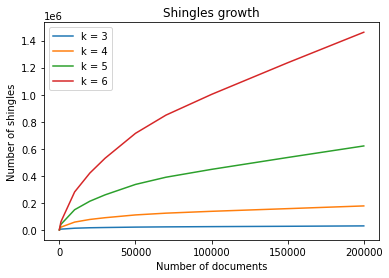

In [41]:
for k in [3, 4, 5, 6]:
    plt.plot(
        results[k]['docs'], 
        results[k]['shingles'],
        label=f'k = {k}'
    )
plt.xticks([0, 50000, 100000, 150000, 200000])
plt.xlabel('Number of documents')
plt.ylabel('Number of shingles')
plt.title('Shingles growth')
plt.legend(loc='best')
plt.savefig('img/shingles_growth.png', dpi=300)

In [69]:
68 ** 3

314432

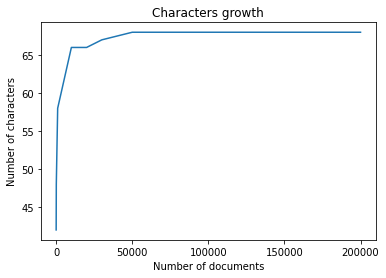

In [42]:
plt.plot(
    results[5]['docs'], 
    results[5]['characters']
)
plt.xticks([0, 50000, 100000, 150000, 200000])
plt.xlabel('Number of documents')
plt.ylabel('Number of characters')
plt.title('Characters growth')
plt.savefig('img/char_growth.png', dpi=300)

## Number of hash bits

In [102]:
results = dict()

for k in [3, 4, 5]:
    ls = []

    for n_bits in [12, 14, 16, 18, 19, 20, 22]:
        ckpt_path = f'checkpoints/k{k}_n_bits{n_bits}'
        time_path = f'{ckpt_path}/time.npy'

        model = LSHModel(
            k=k,
            threshold=0.1,
            num_hashes=100,
            shingle_hash_bits=n_bits,
            track_shingles=True,
            checkpoint_path=ckpt_path
        )

        if os.path.isdir(ckpt_path) and \
            len(os.listdir(ckpt_path)) > 0:
            model.load_checkpoint()

            time_delta = np.load(
                f'{ckpt_path}/time.npy', 
                allow_pickle=True
            )

            sig_tp = dict(model.get_similar_pairs())
            
        else:
            start_time = timeit.default_timer()

            model = train_model(
                model=model, 
                data_path=DATA_PATH,
                num_docs=100,
                verbose=False,
                filtering_pipeline=filtering_pipeline,
                preprocessing_pipeline=preprocessing_pipeline,
            )
            model.save_checkpoint()

            sig_tp = dict(model.get_similar_pairs())

            end_time = timeit.default_timer()
            time_delta = end_time - start_time
            np.save(f'{ckpt_path}/time.npy', time_delta)

        cm_tp, _ = model.check_threshold_on_cm()
        cm_tp = dict(cm_tp)
        num_wrong, mae = evaluate_on_cm(sig_tp, cm_tp)
        correct = len(sig_tp) - num_wrong
        ratio = correct / len(sig_tp)

        ls.append(
            (
                n_bits, 
                correct, 
                num_wrong,
                ratio,
                mae,
                str(datetime.timedelta(seconds=int(time_delta)))
            )
        )

        print(
            f'[k {k}, {n_bits} bits]:\n'
            f'\t{time_delta} seconds\n'
            f'\t{num_wrong} wrong out of {len(sig_tp)} ({ratio} Prec.) (0.1 t)\n'
            f'\t{mae} MAE\n'
        )
    
    results[k] = pd.DataFrame(
        ls,
        columns=[
            'Hash bits',  
            'True Positive', 
            'False Positive', 
            'Precision',
            'MAE',
            'Time delta'
        ]
    ).set_index('Hash bits')

Loaded signature from row 4095


[k 3, 12 bits]:
	126.71929529999034 seconds
	560 wrong out of 1849 (0.6971335857220119 Prec.) (0.1 t)
	0.020856793723282738 MAE

Loaded signature from row 16383


[k 3, 14 bits]:
	131.145119599998 seconds
	738 wrong out of 1683 (0.5614973262032086 Prec.) (0.1 t)
	0.02331308780418188 MAE

Loaded signature from row 65535


[k 3, 16 bits]:
	148.52529530000174 seconds
	328 wrong out of 1033 (0.6824782187802517 Prec.) (0.1 t)
	0.018028087192801467 MAE

Loaded signature from row 262143


[k 3, 18 bits]:
	225.7762883999967 seconds
	374 wrong out of 1096 (0.6587591240875912 Prec.) (0.1 t)
	0.019669841175705357 MAE

Loaded signature from row 524287


[k 3, 19 bits]:
	327.96639620000497 seconds
	500 wrong out of 1267 (0.6053670086819258 Prec.) (0.1 t)
	0.019494177990565863 MAE

Loaded signature from row 1048575


[k 3, 20 bits]:
	530.020795599994 seconds
	413 wrong out of 1192 (0.6535234899328859 Prec.) (0.1 t)
	0.01901903316250552 MAE

Loaded signature from row 4194303


[k 3, 22 bits]:
	1735.1028907 seconds
	457 wrong out of 1170 (0.6094017094017095 Prec.) (0.1 t)
	0.019623296364483924 MAE

Loaded signature from row 4095


[k 4, 12 bits]:
	129.76038419999531 seconds
	256 wrong out of 387 (0.3385012919896641 Prec.) (0.1 t)
	0.02396775106922397 MAE

Loaded signature from row 16383


[k 4, 14 bits]:
	132.80954700001166 seconds
	130 wrong out of 195 (0.3333333333333333 Prec.) (0.1 t)
	0.021991536445698026 MAE

Loaded signature from row 65535


[k 4, 16 bits]:
	149.91380009999557 seconds
	140 wrong out of 206 (0.32038834951456313 Prec.) (0.1 t)
	0.024214348369527433 MAE

Loaded signature from row 262143


[k 4, 18 bits]:
	221.86306370000239 seconds
	121 wrong out of 173 (0.30057803468208094 Prec.) (0.1 t)
	0.018019053603129255 MAE

Loaded signature from row 524287


[k 4, 19 bits]:
	326.6661482999916 seconds
	41 wrong out of 77 (0.4675324675324675 Prec.) (0.1 t)
	0.018005098217007118 MAE

Loaded signature from row 1048575


[k 4, 20 bits]:
	521.0724293999956 seconds
	56 wrong out of 102 (0.45098039215686275 Prec.) (0.1 t)
	0.017650218645583998 MAE

Loaded signature from row 4194303


[k 4, 22 bits]:
	1748.2637592999963 seconds
	245 wrong out of 314 (0.2197452229299363 Prec.) (0.1 t)
	0.020916576133878675 MAE

Loaded signature from row 4095


[k 5, 12 bits]:
	129.07094489999872 seconds
	186 wrong out of 240 (0.225 Prec.) (0.1 t)
	0.022736170989600055 MAE

Loaded signature from row 16383


[k 5, 14 bits]:
	132.21641530000488 seconds
	165 wrong out of 197 (0.16243654822335024 Prec.) (0.1 t)
	0.021176596394318348 MAE

Loaded signature from row 65535


[k 5, 16 bits]:
	151.0643485999899 seconds
	26 wrong out of 55 (0.5272727272727272 Prec.) (0.1 t)
	0.020745237543803415 MAE

Loaded signature from row 262143


[k 5, 18 bits]:
	227.1819386999996 seconds
	82 wrong out of 105 (0.21904761904761905 Prec.) (0.1 t)
	0.01895676801622809 MAE

Loaded signature from row 524287


[k 5, 19 bits]:
	328.3041788999981 seconds
	151 wrong out of 176 (0.14204545454545456 Prec.) (0.1 t)
	0.034204087012169475 MAE

Loaded signature from row 1048575


[k 5, 20 bits]:
	524.3982208999951 seconds
	76 wrong out of 107 (0.2897196261682243 Prec.) (0.1 t)
	0.02064074229973891 MAE

Loaded signature from row 4194303


[k 5, 22 bits]:
	1758.3590567999927 seconds
	24 wrong out of 42 (0.42857142857142855 Prec.) (0.1 t)
	0.021350563069416746 MAE



In [103]:
for k in [3, 4, 5]:
    print(results[k].round(3).to_latex()) 

\begin{tabular}{lrrrrl}
\toprule
{} &  True Positive &  False Positive &  Precision &    MAE & Time delta \\
Hash bits &                &                 &            &        &            \\
\midrule
12        &           1289 &             560 &      0.697 &  0.021 &    0:02:06 \\
14        &            945 &             738 &      0.561 &  0.023 &    0:02:11 \\
16        &            705 &             328 &      0.682 &  0.018 &    0:02:28 \\
18        &            722 &             374 &      0.659 &  0.020 &    0:03:45 \\
19        &            767 &             500 &      0.605 &  0.019 &    0:05:27 \\
20        &            779 &             413 &      0.654 &  0.019 &    0:08:50 \\
22        &            713 &             457 &      0.609 &  0.020 &    0:28:55 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrl}
\toprule
{} &  True Positive &  False Positive &  Precision &    MAE & Time delta \\
Hash bits &                &                 &            &        &            \\

In [84]:
results[3]['Time delta (s)']

Hash bits
12    126.71929529999034
14      131.145119599998
16    148.52529530000174
18     225.7762883999967
19    327.96639620000497
20      530.020795599994
22          1735.1028907
Name: Time delta (s), dtype: object

## Threshold choice

In [44]:
results = dict()

for k in [3, 4, 5]:
    ls = []

    for t in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5]:
        ckpt_path = f'checkpoints/k{k}_t{t}'

        model = LSHModel(
            k=k,
            threshold=t,
            num_hashes=100,
            shingle_hash_bits=16,
            track_shingles=True,
            checkpoint_path=ckpt_path
        )

        if os.path.isdir(ckpt_path) and \
            len(os.listdir(ckpt_path)) > 0:
            model.load_checkpoint()
            sig_tp = dict(model.get_similar_pairs())
            
        else:
            model = train_model(
                model=model, 
                data_path=DATA_PATH,
                num_docs=100,
                verbose=False,
                filtering_pipeline=filtering_pipeline,
                preprocessing_pipeline=preprocessing_pipeline,
            )
            model.save_checkpoint()
            sig_tp = dict(model.get_similar_pairs())

        cm_tp, _ = model.check_threshold_on_cm()
        cm_tp = dict(cm_tp)
        num_wrong, mae = evaluate_on_cm(sig_tp, cm_tp)
        correct = len(sig_tp) - num_wrong
        ratio = correct / (len(sig_tp) or 1e-10)

        ls.append(
            (
                t,
                len(sig_tp),
                correct, 
                num_wrong,
                ratio,
                mae
            )
        )

        print(
            f'[k {k}, {t} threshold]:\n'
            f'\t{num_wrong} wrong out of {len(sig_tp)} ({ratio} Prec.)\n'
            f'\t{mae} MAE\n'
        )
    
    results[k] = pd.DataFrame(
        ls,
        columns=[
            'Threshold', 
            'Predicted pairs',
            'Correct pairs (TP)', 
            'Wrong pairs (FP)', 
            'Correct ratio (Prec.)',
            'MAE'
        ]
    ).set_index('Threshold')

[k 3, 0.05 threshold]:
	263 wrong out of 4003 (0.9342992755433425 Prec.)
	0.01853663028815376 MAE



[k 3, 0.1 threshold]:
	643 wrong out of 1567 (0.589661774090619 Prec.)
	0.021131406471689842 MAE



[k 3, 0.15 threshold]:
	449 wrong out of 528 (0.14962121212121213 Prec.)
	0.03557076007967215 MAE



[k 3, 0.2 threshold]:
	85 wrong out of 89 (0.0449438202247191 Prec.)
	0.03527509312393034 MAE



[k 3, 0.25 threshold]:
	3 wrong out of 5 (0.4 Prec.)
	0.05229437229437231 MAE



[k 3, 0.3 threshold]:
	1 wrong out of 2 (0.5 Prec.)
	0.01969696969696977 MAE



[k 3, 0.5 threshold]:
	0 wrong out of 1 (1.0 Prec.)
	0.05969696969696969 MAE



[k 4, 0.05 threshold]:
	838 wrong out of 2093 (0.599617773530817 Prec.)
	0.01886133192076209 MAE



[k 4, 0.1 threshold]:
	189 wrong out of 265 (0.28679245283018867 Prec.)
	0.020535535327599136 MAE



[k 4, 0.15 threshold]:
	10 wrong out of 17 (0.4117647058823529 Prec.)
	0.020766672904823594 MAE



[k 4, 0.2 threshold]:
	2 wrong out of 5 (0.6 Prec.)
	0.014939526333078138 MAE



[k 4, 0.25 threshold]:
	1 wrong out of 2 (0.5 Prec.)
	0.10223021582733816 MAE



[k 4, 0.3 threshold]:
	0 wrong out of 1 (1.0 Prec.)
	0.02776978417266185 MAE



[k 4, 0.5 threshold]:
	0 wrong out of 1 (1.0 Prec.)
	0.057769784172661875 MAE



[k 5, 0.05 threshold]:
	540 wrong out of 963 (0.4392523364485981 Prec.)
	0.01797396636815996 MAE



[k 5, 0.1 threshold]:
	22 wrong out of 41 (0.4634146341463415 Prec.)
	0.017473547739802673 MAE



[k 5, 0.15 threshold]:
	3 wrong out of 6 (0.5 Prec.)
	0.01152047109181221 MAE



[k 5, 0.2 threshold]:
	0 wrong out of 1 (1.0 Prec.)
	0.11126760563380289 MAE



[k 5, 0.25 threshold]:
	0 wrong out of 1 (1.0 Prec.)
	0.011267605633802913 MAE



[k 5, 0.3 threshold]:
	0 wrong out of 1 (1.0 Prec.)
	0.04126760563380283 MAE



[k 5, 0.5 threshold]:
	0 wrong out of 1 (1.0 Prec.)
	0.021267605633802922 MAE



In [ ]:
for k in [3, 4, 5]:
    print(results[k].round(3))

## Number of hash functions

In [46]:
results = dict()

for k in [3, 4, 5]:
    ls = []

    for num_hashes in [20, 100, 200, 300, 500]:
        ckpt_path = f'checkpoints/k{k}_n_hash{num_hashes}'
        time_path = f'{ckpt_path}/time.npy'

        model = LSHModel(
            k=k,
            threshold=0.1,
            num_hashes=num_hashes,
            shingle_hash_bits=16,
            track_shingles=True,
            checkpoint_path=ckpt_path
        )

        if os.path.isdir(ckpt_path) and \
            len(os.listdir(ckpt_path)) > 0:
            model.load_checkpoint()
            sig_tp = dict(model.get_similar_pairs())
            time_delta = np.load(
                f'{ckpt_path}/time.npy', 
                allow_pickle=True
            )
            
        else:
            start_time = timeit.default_timer()

            model = train_model(
                model=model, 
                data_path=DATA_PATH,
                num_docs=100,
                verbose=False,
                filtering_pipeline=filtering_pipeline,
                preprocessing_pipeline=preprocessing_pipeline,
            )
            model.save_checkpoint()

            sig_tp = dict(model.get_similar_pairs())

            end_time = timeit.default_timer()
            time_delta = end_time - start_time
            np.save(f'{ckpt_path}/time.npy', time_delta)

        cm_tp, _ = model.check_threshold_on_cm()
        cm_tp = dict(cm_tp)
        num_wrong, mae = evaluate_on_cm(sig_tp, cm_tp)
        correct = len(sig_tp) - num_wrong
        ratio = correct / (len(sig_tp) or 1e-10)

        ls.append(
            (
                num_hashes,
                time_delta,
                len(sig_tp),
                correct, 
                num_wrong,
                ratio,
                mae
            )
        )

        print(
            f'[k {k}, {num_hashes} hashes]:\n'
            f'\t{time_delta} seconds\n'
            f'\t{num_wrong} wrong out of {len(sig_tp)} ({ratio} Prec.)\n'
            f'\t{mae} MAE\n'
        )
    
    results[k] = pd.DataFrame(
        ls,
        columns=[
            'Num hashes', 
            'Time delta (s)',
            'Predicted pairs',
            'Correct pairs (TP)', 
            'Wrong pairs (FP)', 
            'Correct ratio (Prec.)',
            'MAE'
        ]
    ).set_index('Num hashes')

Loaded signature from row 65535


[k 3, 20 hashes]:
	145.9052531000052 seconds
	1338 wrong out of 2206 (0.39347234814143245 Prec.)
	0.052367203436529224 MAE

Loaded signature from row 65535


[k 3, 100 hashes]:
	147.84881979999773 seconds
	1409 wrong out of 2592 (0.4564043209876543 Prec.)
	0.03314316720473631 MAE

Loaded signature from row 65535


[k 3, 200 hashes]:
	153.4122917999921 seconds
	370 wrong out of 1182 (0.6869712351945855 Prec.)
	0.015046858749930793 MAE



[k 3, 300 hashes]:
	228.9080074999947 seconds
	5 wrong out of 75 (0.9333333333333333 Prec.)
	0.01400997426216058 MAE

Loaded signature from row 65535


[k 3, 500 hashes]:
	167.87862210000458 seconds
	0 wrong out of 0 (0.0 Prec.)
	0.0 MAE



Loaded signature from row 65535


[k 4, 20 hashes]:
	147.47056610000436 seconds
	317 wrong out of 349 (0.09169054441260745 Prec.)
	0.04861744791810006 MAE

Loaded signature from row 65535


[k 4, 100 hashes]:
	150.08517599999323 seconds
	94 wrong out of 149 (0.3691275167785235 Prec.)
	0.02232167842872903 MAE

Loaded signature from row 65535


[k 4, 200 hashes]:
	155.88582860000315 seconds
	32 wrong out of 84 (0.6190476190476191 Prec.)
	0.01613812694850505 MAE



[k 4, 300 hashes]:
	167.60168950000661 seconds
	3 wrong out of 9 (0.6666666666666666 Prec.)
	0.018145034848813264 MAE

Loaded signature from row 65535


[k 4, 500 hashes]:
	170.6709533999965 seconds
	0 wrong out of 0 (0.0 Prec.)
	0.0 MAE



[k 5, 20 hashes]:
	150.87223180000728 seconds
	529 wrong out of 554 (0.04512635379061372 Prec.)
	0.044428817538577324 MAE



[k 5, 100 hashes]:
	151.88017550000222 seconds
	48 wrong out of 70 (0.3142857142857143 Prec.)
	0.017716559624736065 MAE



[k 5, 200 hashes]:
	163.66354339999089 seconds
	27 wrong out of 51 (0.47058823529411764 Prec.)
	0.017829924243386332 MAE



[k 5, 300 hashes]:
	174.51995030000398 seconds
	0 wrong out of 1 (1.0 Prec.)
	0.02793427230046952 MAE



[k 5, 500 hashes]:
	175.46904840000207 seconds
	0 wrong out of 1 (1.0 Prec.)
	0.02673239436619712 MAE



## 100k Tweets comparison

### Train LSH model

MORE THAN ONE MODEL?

In [15]:
ckpt_path = f'checkpoints/d100k/k4_t0.4_n_hashes200_n_bits18'
# ckpt_path = f'checkpoints/d100k/k3_t0.4_n_hashes200_n_bits16'
# ckpt_path = f'checkpoints/d100k/k5_t0.6_n_hashes200_n_bits16'
model = LSHModel(
    k=5,
    threshold=0.6,
    num_hashes=200,
    shingle_hash_bits=16,
    track_shingles=True,
    checkpoint_path=ckpt_path
)
model = train_model(
    model=model, 
    data_path=DATA_PATH,
    num_docs=100000,
    verbose=True,
    filtering_pipeline=filtering_pipeline,
    preprocessing_pipeline=preprocessing_pipeline
)

Adding documents to model:   0%|          | 0/100000 [00:00<?, ?it/s]

Reading file e:\datasets\ukraine\0401_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0402_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0403_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0404_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0405_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0406_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0407_UkraineCombinedTweetsDeduped.csv.gzip


Filtered 1714663 rows in files, kept 221615


In [51]:
results = dict()
configs = [
    {'k': 3, 'threshold': 0.6, 'num_hashes': 200, 'shingle_hash_bits': 16},
    # {'k': 4, 'threshold': 0.6, 'num_hashes': 200, 'shingle_hash_bits': 18},
    # {'k': 5, 'threshold': 0.6, 'num_hashes': 200, 'shingle_hash_bits': 16}
]

for idx, config in enumerate(configs):
    ckpt_path = 'checkpoints/d100k/k{k}_t{threshold}_n_hashes{num_hashes}_n_bits{shingle_hash_bits}' \
        .format(**config)
    
    model = LSHModel(
        **config,
        track_shingles=True,
        checkpoint_path=ckpt_path
    )
    model = train_model(
        model=model, 
        data_path=DATA_PATH,
        num_docs=100000,
        verbose=True,
        filtering_pipeline=filtering_pipeline,
        preprocessing_pipeline=preprocessing_pipeline
    )

    similar_pairs = model.get_similar_pairs()
    sig_tp = dict(similar_pairs)
    cm_tp, _ = model.check_threshold_on_cm()
    cm_tp = dict(cm_tp)
    num_wrong, mae = evaluate_on_cm(sig_tp, cm_tp)
    num_correct = len(sig_tp) - num_wrong
    ratio = num_correct / len(sig_tp)

    results[idx] = {
        'similar_pairs': similar_pairs,
        'num_total': len(similar_pairs),
        'num_correct': num_correct,
        'num_wrong': num_wrong,
        'ratio': ratio,
        'mae': mae
    }

Adding documents to model:   0%|          | 0/100000 [00:00<?, ?it/s]

Reading file e:\datasets\ukraine\0401_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0402_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0403_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0404_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0405_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0406_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0407_UkraineCombinedTweetsDeduped.csv.gzip


Filtered 1714663 rows in files, kept 221615
Loaded signature from row 65535


d:\Users\gabri\anaconda3\envs\tf_p3.9\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The number of calls to function has reached maxfev = 600.
  warnings.warn(msg, RuntimeWarning)


In [52]:
results

{0: {'similar_pairs': {((80166, 92247), 0.66),
   ((78933, 86135), 0.795),
   ((82300, 88432), 0.68),
   ((85266, 91540), 0.625),
   ((90679, 91944), 0.625),
   ((88337, 89098), 0.665),
   ((87314, 88676), 0.69),
   ((82815, 90392), 0.635),
   ((91870, 92911), 0.795),
   ((79097, 82708), 0.64),
   ((80343, 89098), 0.705),
   ((77889, 80298), 0.755),
   ((80378, 86372), 0.805),
   ((80895, 90958), 0.64),
   ((86325, 86510), 0.82),
   ((81884, 86353), 0.82),
   ((55930, 59113), 0.875),
   ((20213, 55141), 0.675),
   ((11929, 52696), 0.69),
   ((78635, 82355), 0.695),
   ((79508, 82351), 0.755),
   ((5759, 5840), 0.665),
   ((60137, 61177), 0.835),
   ((14676, 57641), 0.76),
   ((17694, 17992), 0.705),
   ((80283, 90793), 0.725),
   ((45649, 45726), 0.675),
   ((79097, 80826), 0.685),
   ((79530, 82300), 0.835),
   ((79860, 84963), 0.67),
   ((50906, 63857), 0.785),
   ((83355, 84210), 0.655),
   ((79468, 93691), 0.77),
   ((80166, 82643), 0.67),
   ((21243, 86075), 0.675),
   ((77350, 77

### MPNet embeddings

CHECK ONLY ON PAIRS WITH < 0.9 or 0.8

In [62]:
tokenizer = AutoTokenizer.from_pretrained(
    'sentence-transformers/all-mpnet-base-v2'
)
mpnet = AutoModel.from_pretrained(
    'sentence-transformers/all-mpnet-base-v2'
).to(device)

In [67]:
mpnet_preprocessing = [
    remove_https,
    strip_accents,
    remove_non_ascii,
    replace_chars,
    normalize_white_space
]

In [68]:
for idx in range(len(results)):
    model_results = results[idx]

    correlations = compare_similarity(
        model=mpnet,
        tokenizer=tokenizer,
        data_path=DATA_PATH,
        model_preprocessing=mpnet_preprocessing,
        filtering_pipeline=filtering_pipeline,
        similar_pairs=model_results['similar_pairs'],
        device=device
    )

    # results[idx]['kendall'] = correlations[kendall_corr
    # results[idx]['spearman'] = spearman_corr

File block:   0%|          | 0/18 [00:00<?, ?it/s]

Reading file e:\datasets\ukraine\0401_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0402_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0403_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0404_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0405_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0406_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0407_UkraineCombinedTweetsDeduped.csv.gzip


Computing similarity for each doc:   1%|          | 132/15637 [00:09<18:35, 13.90it/s]d:\Users\gabri\anaconda3\envs\tf_p3.9\lib\site-packages\scipy\stats\_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [66]:
sorted(
    correlations['doc_sims'],
    key=lambda x: x[2][0]
)

[(0,
  KendalltauResult(correlation=nan, pvalue=nan),
  SpearmanrResult(correlation=nan, pvalue=nan),
  [0.96],
  [array(0.99157095, dtype=float32)]),
 (9,
  KendalltauResult(correlation=-1.0, pvalue=1.0),
  SpearmanrResult(correlation=-0.9999999999999999, pvalue=nan),
  [0.73, 0.775],
  [array(0.9549786, dtype=float32), array(0.9342413, dtype=float32)]),
 (33,
  KendalltauResult(correlation=-0.33333333333333337, pvalue=1.0),
  SpearmanrResult(correlation=-0.5, pvalue=0.6666666666666667),
  [0.605, 0.83, 0.81],
  [array(0.9285729, dtype=float32),
   array(0.8780321, dtype=float32),
   array(0.9774473, dtype=float32)]),
 (51,
  KendalltauResult(correlation=0.24078203063740672, pvalue=0.30856458676045817),
  SpearmanrResult(correlation=0.33790306608314513, pvalue=0.30947476272949803),
  [0.68, 0.935, 0.935, 0.925, 0.87, 0.975, 0.98, 0.995, 0.85, 0.945, 0.87],
  [array(0.9547618, dtype=float32),
   array(0.99443984, dtype=float32),
   array(0.987337, dtype=float32),
   array(0.9875587, dt

In [60]:
get_text([9, 4175, 1219], DATA_PATH, filtering_pipeline=filtering_pipeline)

File block:   0%|          | 0/18 [00:00<?, ?it/s]

Reading file e:\datasets\ukraine\0401_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0402_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0403_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0404_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0405_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0406_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0407_UkraineCombinedTweetsDeduped.csv.gzip


[(9,
  '#Russia’s President Vladimir #Putin says he has signed a decree saying foreign buyers must pay in rubles for Russian gas from April 1, and contracts would be halted if these payments are not made.\n\nhttps://t.co/IUBuHMgw4n',
  index                                                            10
  userid                                                     22240612
  username                                              AlArabiya_Eng
  acctdesc          The Arab world’s leading source of global news...
  location                                                      Dubai
  following                                                        45
  followers                                                    911972
  totaltweets                                                  313091
  usercreatedts                            2009-02-28 08:31:32.000000
  tweetid                                         1509681953418752008
  tweetcreatedts                           2022-04-01 00:00:00.000

In [59]:
[pair for pair in results[0]['similar_pairs'] if 9 in pair[0]]

[((9, 4175), 0.73), ((9, 1219), 0.775)]

### Compare rankings

### Comparison test

In [10]:
sentences = [
    'I went to the bank to withdraw money and compensate the plaintiff for their losses.',
    'The Russians are withdrawing from the banks of the Dnipro River after suffering heavy losses.',
    'After the judgement, I had to use my debit card and pay the suer for the damages.'
]

#### Jaccard similarity with shingles

In [41]:
docs_dict = dict()
k = 3

for i, sentence in enumerate(sentences):

    shingles = set()

    for f in [
        str.lower,
        strip_punctuation,
        get_lemmatizer(nlp),
        normalize_white_space
    ]:
        sentence = f(sentence)

    for j in range(len(sentence[:-k+1])):
        shingle = sentence[j:j+k]
        shingles.add(shingle)

    docs_dict[i] = shingles

for i, _ in enumerate(sentences):
    for j in range(i+1, len(sentences)):
        sim = jaccard_similarity(
            docs_dict[i], docs_dict[j]
        )
        print(((i,j), round(sim, 3)))

((0, 1), 0.185)
((0, 2), 0.0)
((1, 2), 0.023)


#### MPNet

In [43]:
tokenizer = AutoTokenizer.from_pretrained(
    'sentence-transformers/all-mpnet-base-v2'
)
mpnet = AutoModel.from_pretrained(
    'sentence-transformers/all-mpnet-base-v2'
).to(device)

encoded_input = tokenizer(
    sentences, 
    padding='max_length', 
    truncation=True, 
    return_tensors='pt'
).to(device)

with torch.no_grad():
    model_output = mpnet(**encoded_input)

embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

for i, _ in enumerate(sentences):
    for j in range(i+1, len(sentences)):
        sim = torch_cosine_similarity(
            embeddings[i],
            embeddings[j],
        )
        print(((i,j), sim.cpu().numpy().round(3)))

((0, 1), 0.192)
((0, 2), 0.648)
((1, 2), 0.131)


In [ ]:
ckpt_path = f'checkpoints/test/test1'
model = LSHModel(
    k=5,
    threshold=0.1,
    num_hashes=100,
    shingle_hash_bits=16,
    track_shingles=True,
    checkpoint_path=ckpt_path
)

num_docs = 100

files = []
data_path = DATA_PATH

for name in os.listdir(data_path):
    full_path = os.path.join(data_path, name)
    if os.path.isfile(full_path):
        files.append(full_path)

duplicates = 0
count = num_docs

with tqdm(
    total=num_docs,
    desc='Adding documents to model',
    leave=False
) as pbar:
    for file in files:
        if count == 0:
            break
        
        print(f'Reading file {file}')
        df = pd.read_csv(
            file, 
            compression='gzip', 
            index_col=0,
            encoding='utf-8', 
            quoting=csv.QUOTE_ALL,
            low_memory=False
        )

        df = df[df['language'] == 'en']

        for filter_f in filtering_pipeline:
            df['text'] = df['text'].apply(filter_f)

        df_unique = df.drop_duplicates(subset=['text'])
        duplicates += len(df) - len(df_unique)

In [ ]:
# List of Tuples
matrix = [('22', '34', '23'),
         ('33', '31', '11'),
         ('44', '16', '21'),
         ('55', '32', '22'),
         ('66', '33', '27'),
         ('77', '35', '11')
         ]
# Create a DataFrame object
dfObj = pd.DataFrame(matrix, columns=list('xyz'), index=list('abcdef'))

In [ ]:
dfObj

In [ ]:
dfObj['z'] = dfObj['z'].apply(remove_https)
dfObj

In [ ]:
remove_https('ababss')

In [ ]:
matrix = [('22', '34', '23'),
         ('33', '31', '11'),
         ('44', '16', '21'),
         ('22', '34', '23'),
         ('66', '33', '27'),
         ('22', '34', '23')
         ]
# Create a DataFrame object
dd = pd.DataFrame(matrix, columns=list('xyz'), index=list('abcdef'))
dd

In [ ]:
dd1 = dd.drop_duplicates()
dd1

In [ ]:
dd.loc[dd1.index]

In [ ]:
s = '@mr_589_ putin is a cancer to the world. @russia need to overthrow him asap. stand with @ukraine! #standwithukraine'

In [ ]:
def remove_handles(doc: str) -> str:
    return re.sub(r'@\w+', '', doc)

In [ ]:
remove_handles(s)

In [ ]:
def remove_short(n: int):
    def inner_f(doc: str):
        if len(doc) < n:
            return ''
        else:
            return doc

    return inner_f

In [ ]:
import nltk
nltk.download('stopwords')

In [ ]:
remover = get_stopwords_remover(stops)

In [ ]:
s = "Hey, #Ukraine is not just angry ( understatement!) At @KremlinRussia_E . It's angry at the rest of the world as well for allowing this war to happen. \n\nAnd you know what? It has every right to be so.\n\nI simply understand it. \n\nThis war can be stopped within 5 minutes."
ss = remover(s.lower())
ss

In [ ]:
lemmatizer = get_lemmatizer(nlp)

In [ ]:
lemmatizer(ss)

In [ ]:
len(stops)

In [79]:
2**15

32768